# 1. Reading the data

In [60]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [61]:
files_train = get_image_files("Train")
files_valid = get_image_files("validate")

In [1]:
# len(files_train), len(files_valid)

In [63]:
df_train = pd.DataFrame(files_train,columns=["name"])
df_train.name = df_train.name.apply(str)
df_train["label"] = df_train.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_train["label"] = df_train.label.apply(lambda x: re.sub("_"," ", x))
df_train["age"] = df_train.label.apply(lambda x: int(x.split(" ")[0]))
df_train["gender"] = df_train.label.apply(lambda x: int(x.split(" ")[1]))
df_train["ethnicity"] = df_train.label.apply(lambda x: int(x.split(" ")[2]))

In [64]:
df_valid = pd.DataFrame(files_valid,columns=["name"])
df_valid.name = df_valid.name.apply(str)
df_valid["label"] = df_valid.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_valid["label"] = df_valid.label.apply(lambda x: re.sub("_"," ", x))
df_valid["age"] = df_valid.label.apply(lambda x: int(x.split(" ")[0]))
df_valid["gender"] = df_valid.label.apply(lambda x: int(x.split(" ")[1]))
df_valid["ethnicity"] = df_valid.label.apply(lambda x: int(x.split(" ")[2]))

In [65]:
df_train.head()

,name,label,age,gender,ethnicity
0,Train\100_1_0_20170112215032192.jpg.chip.jpg,100 1 0,100,1,0
1,Train\100_1_2_20170105174847679.jpg.chip.jpg,100 1 2,100,1,2
2,Train\105_1_0_20170112213021902.jpg.chip.jpg,105 1 0,105,1,0
3,Train\10_0_0_20170103233459275.jpg.chip.jpg,10 0 0,10,0,0
4,Train\10_0_0_20170104013211746.jpg.chip.jpg,10 0 0,10,0,0


In [66]:
df_valid.head()

,name,label,age,gender,ethnicity
0,validate\100_1_2_20170105174847679.jpg.chip.jpg,100 1 2,100,1,2
1,validate\10_0_0_20170104013211746.jpg.chip.jpg,10 0 0,10,0,0
2,validate\10_0_0_20170110220033115.jpg.chip.jpg,10 0 0,10,0,0
3,validate\10_0_0_20170110220255346.jpg.chip.jpg,10 0 0,10,0,0
4,validate\10_0_0_20170110220403810.jpg.chip.jpg,10 0 0,10,0,0


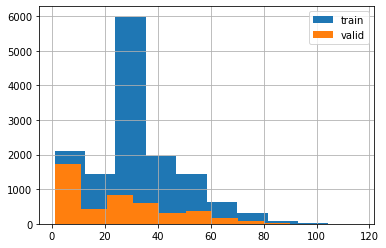

In [67]:
#checking distribution for ages
df_train.age.hist()
df_valid.age.hist()
plt.legend(["train","valid"]);

In [68]:
#should be only 0s and 1s
df_train.gender.unique(), df_valid.gender.unique()

(array([1, 0], dtype=int64), array([1, 0], dtype=int64))

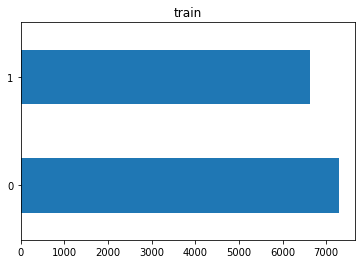

In [69]:
#accuracy is a good metric fore gender
(df_train.gender.value_counts()).plot.barh()
plt.title("train");

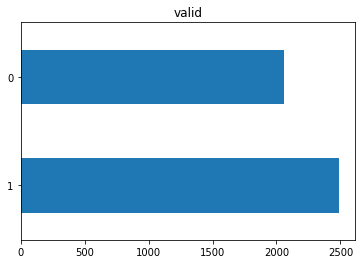

In [70]:
(df_valid.gender.value_counts()).plot.barh()
plt.title("valid");

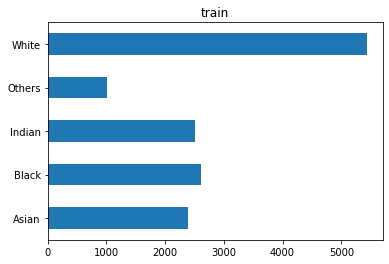

In [38]:
d = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df_train.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("train");

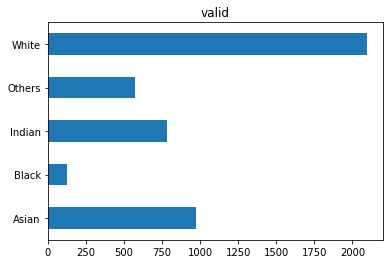

In [39]:
df_valid.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("valid");

# 2. Creating the Datasets, Dataloaders and Databunch

In [40]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [41]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_valid, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
data = DataBunch(train_dl, valid_dl)

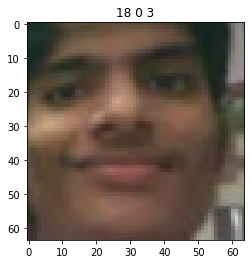

In [42]:
train_ds.show(555)

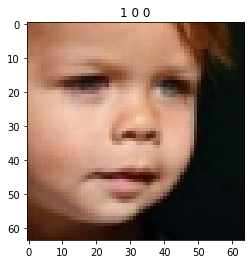

In [43]:
valid_ds.show(500)

In [44]:
class MultiTaskModel(nn.Module):
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024,1,ps=ps)
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return [age, gender, ethnicity]

In [45]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age, gender, ethnicity):

        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages = (age*4.75).exp_()
        idx1 = (sages <20) | ((sages > 40) & (sages <= 60))
        idx2 = sages > 60
        loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2]) #trying to account for the imbalance
        loss1 = crossEntropy(preds[1],gender)
        loss2 = crossEntropy(preds[2],ethnicity)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

# 4. Defining Metrics, Learner and Training

In [46]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [47]:
model = MultiTaskModel(models.resnet34, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

#spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
learn.freeze()

In [24]:
torch.cuda.get_device_name()

'GeForce 920M'

In [25]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce 920M', major=3, minor=5, total_memory=2048MB, multi_processor_count=2)

In [48]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


BrokenPipeError: [Errno 32] Broken pipe

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time
0,2.163357,1.787746,0.230396,0.746728,0.618200,01:32
1,1.734366,1.424151,0.144809,0.785685,0.675767,01:31
2,1.448424,1.299358,0.131512,0.812372,0.712883,01:31
3,1.259158,1.258440,0.123698,0.812679,0.725256,01:33
4,1.130069,1.096699,0.114151,0.838344,0.744581,01:33
5,1.046168,1.008690,0.129513,0.849387,0.781288,01:33
6,0.995858,0.922763,0.116497,0.855317,0.793047,01:33
7,0.943859,0.881247,0.101692,0.871575,0.797648,01:33
8,0.905376,0.846028,0.099847,0.874642,0.806544,01:33
9,0.869369,0.843575,0.105126,0.873006,0.811861,01:33


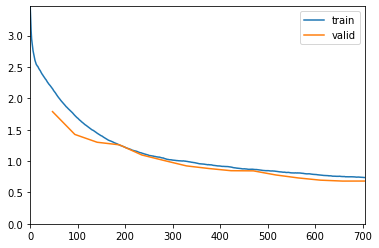

Better model found at epoch 0 with valid_loss value: 1.7877455949783325.
Better model found at epoch 1 with valid_loss value: 1.424150824546814.
Better model found at epoch 2 with valid_loss value: 1.2993577718734741.
Better model found at epoch 3 with valid_loss value: 1.258439540863037.
Better model found at epoch 4 with valid_loss value: 1.0966992378234863.
Better model found at epoch 5 with valid_loss value: 1.008690357208252.
Better model found at epoch 6 with valid_loss value: 0.9227629899978638.
Better model found at epoch 7 with valid_loss value: 0.88124680519104.
Better model found at epoch 8 with valid_loss value: 0.8460281491279602.
Better model found at epoch 9 with valid_loss value: 0.8435753583908081.
Better model found at epoch 10 with valid_loss value: 0.7786056399345398.
Better model found at epoch 11 with valid_loss value: 0.7312471866607666.
Better model found at epoch 12 with valid_loss value: 0.6954948306083679.
Better model found at epoch 13 with valid_loss value:

In [ ]:
learn.fit_one_cycle(15,max_lr=1e-2,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')])

In [18]:
learn.load("stage-1");

NameError: name 'learn' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


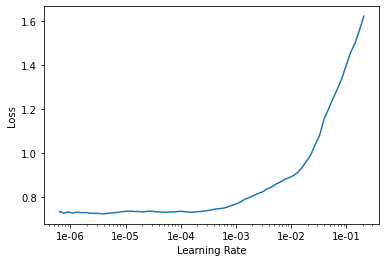

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time
0,0.732540,0.683577,0.087500,0.898466,0.841411,01:32
1,0.726848,0.682371,0.086598,0.898978,0.841207,01:32
2,0.727327,0.678820,0.087188,0.898773,0.842536,01:33
3,0.727599,0.675722,0.087836,0.899591,0.843354,01:33
4,0.729398,0.675490,0.087385,0.898160,0.844376,01:34
5,0.717504,0.670951,0.086383,0.899080,0.845297,01:35
6,0.716383,0.664207,0.086084,0.900920,0.846319,01:35
7,0.717435,0.659837,0.085379,0.902863,0.848364,01:35
8,0.714414,0.654428,0.086514,0.903476,0.848875,01:36
9,0.712131,0.650448,0.085681,0.903885,0.851840,01:36


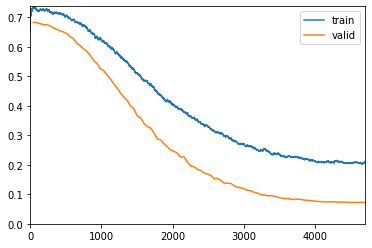

Better model found at epoch 0 with valid_loss value: 0.6835767030715942.
Better model found at epoch 1 with valid_loss value: 0.6823711395263672.
Better model found at epoch 2 with valid_loss value: 0.6788195371627808.
Better model found at epoch 3 with valid_loss value: 0.6757219433784485.
Better model found at epoch 4 with valid_loss value: 0.6754902005195618.
Better model found at epoch 5 with valid_loss value: 0.6709514856338501.
Better model found at epoch 6 with valid_loss value: 0.6642066240310669.
Better model found at epoch 7 with valid_loss value: 0.6598374247550964.
Better model found at epoch 8 with valid_loss value: 0.654427707195282.
Better model found at epoch 9 with valid_loss value: 0.6504475474357605.
Better model found at epoch 10 with valid_loss value: 0.6447869539260864.
Better model found at epoch 11 with valid_loss value: 0.6346135139465332.
Better model found at epoch 12 with valid_loss value: 0.6275506019592285.
Better model found at epoch 13 with valid_loss va

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(100,max_lr=slice(1e-6,3e-4),
                   callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [53]:
learn = learn.load("stage-3")

AttributeError: 'WindowsPath' object has no attribute 'tell'